In [1]:
import genomeview
from genomeview.bamtrack import SingleEndBAMTrack, PairedEndBAMTrack
import genomeview.axis
import genomeview.graphtrack
from genomeview import genomesource

## Download some example data, if necessary

In [2]:
import gzip
import io
import os
import urllib.request

genome_path = "data/chr14.fa"

if not os.path.exists("data/pacbio.chr14.bam"):
    raise Exception("Make sure to run jupyter notebook from the genomeview examples directory.")
    
if not os.path.exists(genome_path):
    print("reference chrom 14 not found; downloading...")
    r = urllib.request.urlopen("http://hgdownload.cse.ucsc.edu/goldenpath/hg19/chromosomes/chr14.fa.gz")
    z = gzip.GzipFile(fileobj=io.BytesIO(r.read()), mode="rb")
    f = open(genome_path, "wb")
    f.write(z.read())
    print("...done.")
else:
    print("Genome and bam files found, no further action required")

Genome and bam files found, no further action required


## Some basic code to visualize a set of bams

In [3]:
track_info = {"illumina":"data/illumina.chr14.bam",
              "pacbio":"data/pacbio.chr14.bam"}
chrom = "14"
start = 66901400

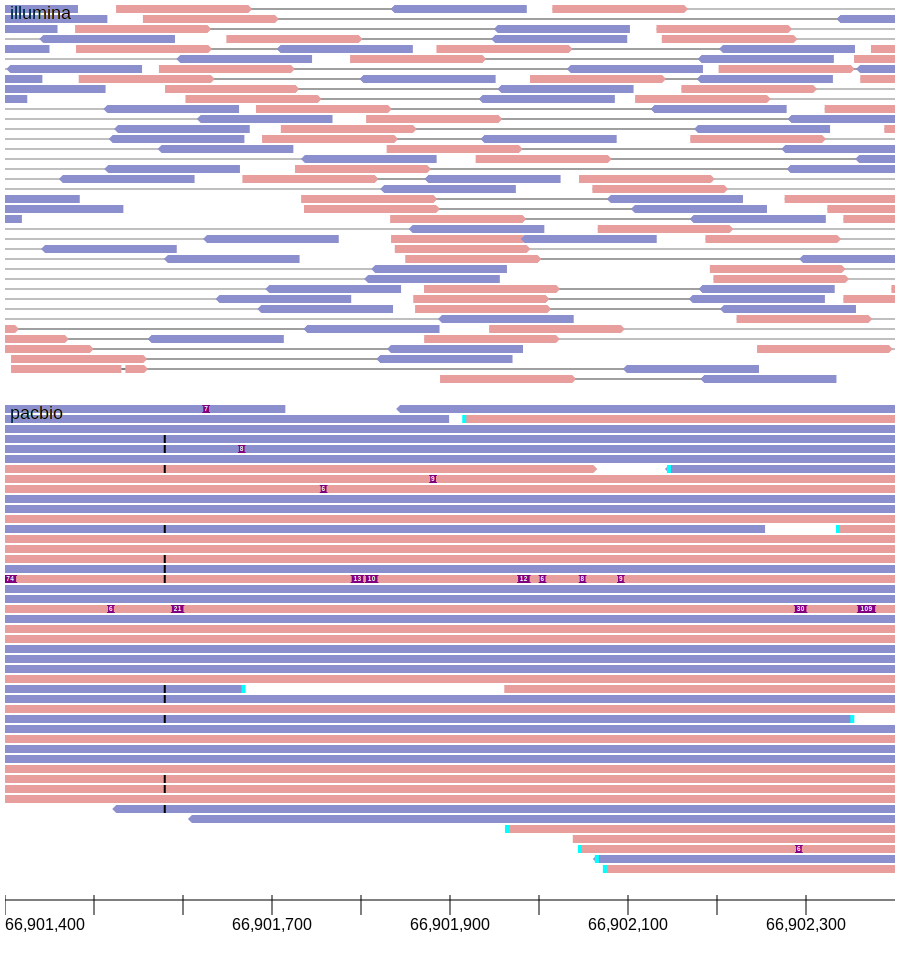

In [4]:
tracks = genomeview.visualize_data(track_info, chrom, start, start+1000, genome_path)
tracks

# Using python to extend functionality

Let's take advantage of the fact that we're doing all the drawing in python, and use a custom function to determine the color of the read pairs.

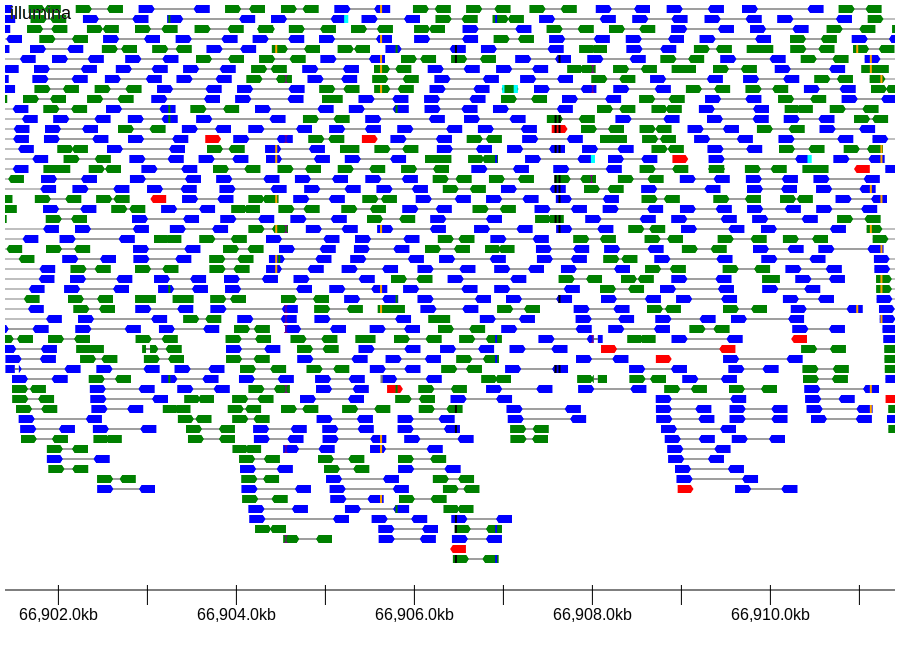

In [5]:
def color_by_insert_size(interval):
    if abs(interval.read.isize) < 100 or abs(interval.read.isize) > 1500:
        return "red"
    if abs(interval.read.isize) > 550:
        return "blue"
    return "green"

# let's just render the illumina data
cur_paths = {key:track_info[key] for key in ["illumina"]}
doc = genomeview.visualize_data(cur_paths, chrom, start, start+10000, genome_path)

track = genomeview.get_one_track(doc, "illumina")
track.color_fn = color_by_insert_size 

doc

**performance is reasonably fast** - note that the pacbio "quick consensus" viewing takes the bulk of the time

In [6]:
%timeit svg = "\n".join(tracks.render())

598 ms ± 795 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Modular design
Components can be grouped together, not only vertically (as above) but also horizontally, as demonstrated below.

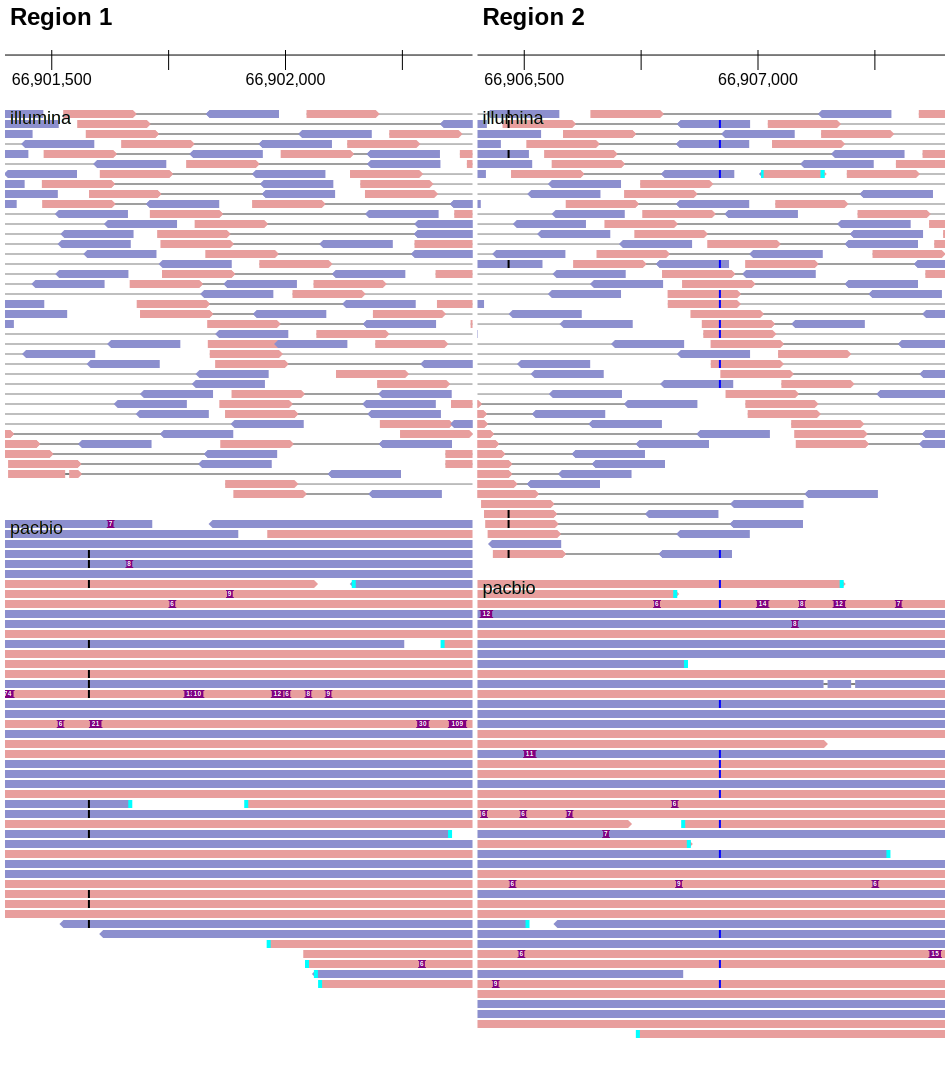

In [7]:
doc = genomeview.Document(950)
source = genomesource.FastaGenomeSource(genome_path)

row = genomeview.ViewRow("row")

for i, cur_start in enumerate([start, start+5000]):
    cur_doc = genomeview.visualize_data(
        track_info, chrom, cur_start, cur_start+1000, genome_path, axis_on_top=True)
    gv = cur_doc.elements[0]

    # Add a text label
    label_track = genomeview.track.TrackLabel("Region {}".format(i+1))
    gv.tracks.insert(0, label_track)
    
    # Add the genome view to the end of the row
    row.add_view(gv)
    
doc.elements.append(row)
doc

## Custom drawing callbacks

Pre-renderers and post-renderers are code that get run before and after (respectively) drawing the track. This allows compositing additional visual elements such as highlighting a genomic region or adding text, without creating a custom Track subclass.

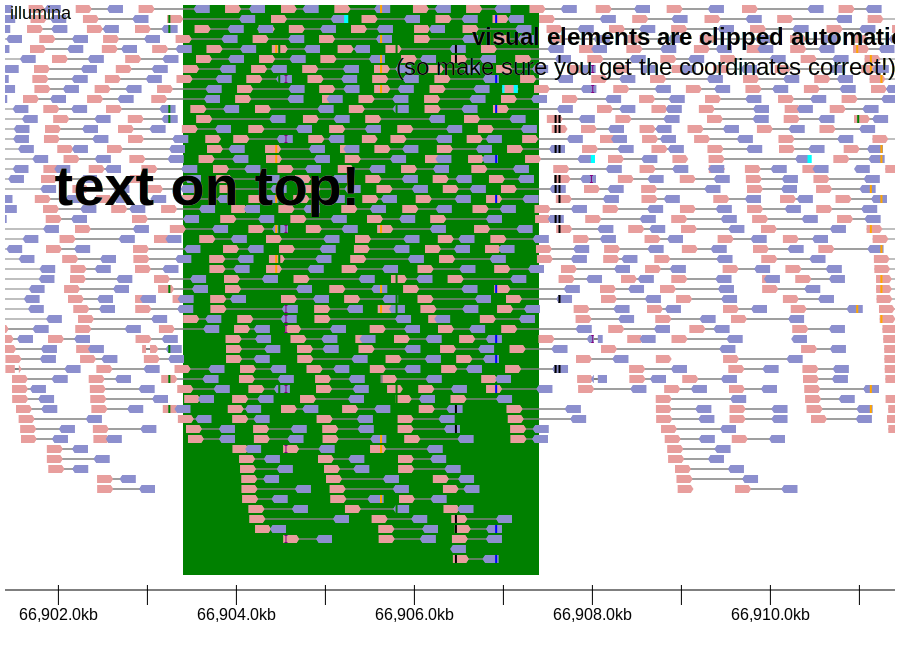

In [8]:
def prerender(renderer, element):
    # prerenderers get run before the track is rendered
    x1 = element.scale.topixels(start+2000) # converting genomic coordinates to screen coordinates
    x2 = element.scale.topixels(start+6000)
    yield from renderer.rect(x1, 0, x2-x1, element.height, fill="green", stroke="none")
    
def postrender(renderer, element):
    # we'll render this with screen coordinates (not genomic coordinates)
    yield from renderer.text_with_background(
        200, 200, "text on top!", size=56, bg_opacity=1.0, **{"font-weight":"bold"})
    
    width = element.scale.pixel_width
    yield from renderer.text_with_background(
        width+50, 40, "visual elements are clipped automatically", size=24, bg_opacity=1.0, 
        anchor="end", **{"font-weight":"bold"})
    yield from renderer.text_with_background(
        width, 70, "(so make sure you get the coordinates correct!)", size=24, bg_opacity=1.0, 
        anchor="end")


doc = genomeview.visualize_data(cur_paths, chrom, start, start+10000, genome_path)
cur_track = genomeview.get_one_track(doc, "illumina")
cur_track.prerenderers = [prerender]
cur_track.postrenderers = [postrender]

doc

# Grouping read data by tag, etc

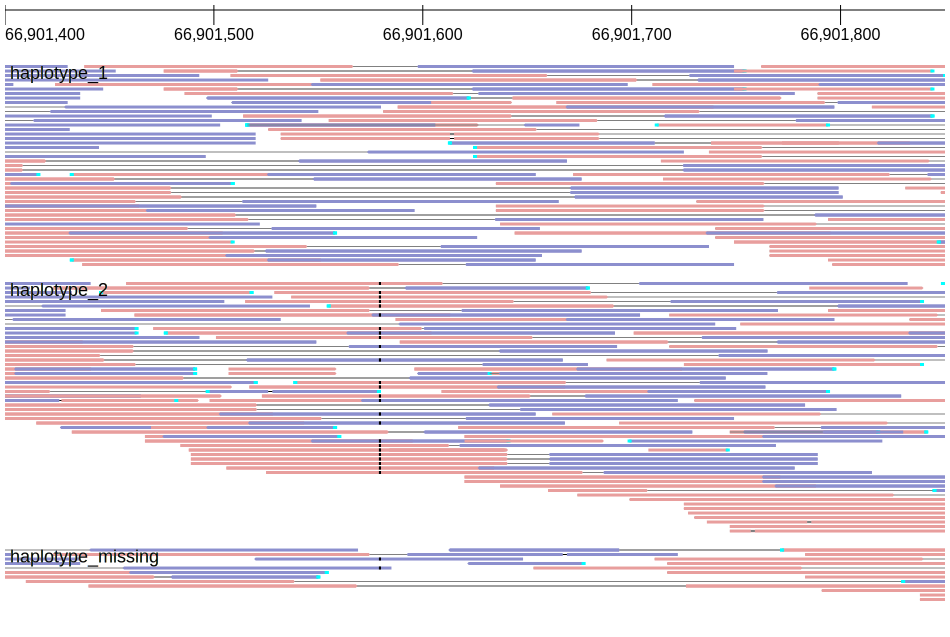

In [9]:
# subclassing so that we can change the default spacing for 
# all the different group views
class MyPairedEndBAMTrack(PairedEndBAMTrack):
    def __init__(self, *args, **kwdargs):
        super().__init__(*args, **kwdargs)
        self.row_height = 3
        self.margin_y = 1.5
        
doc = genomeview.Document(950)
source = genomesource.FastaGenomeSource(genome_path)

gv = genomeview.genomeview.GenomeView(chrom, start, start+450, "+", source)

# Add the coordinate axis at the top
axis = genomeview.axis.Axis()
gv.add_track(axis)

bam_track = genomeview.bamtrack.GroupedBAMTrack("data/10x.chr14.bam", 
                                                genomeview.bamtrack.get_group_by_tag_fn("HP"),
                                                MyPairedEndBAMTrack)
bam_track.category_label_fn = lambda x: "haplotype_{}".format(x)
gv.add_track(bam_track)

doc.elements.append(gv)

doc

# All together

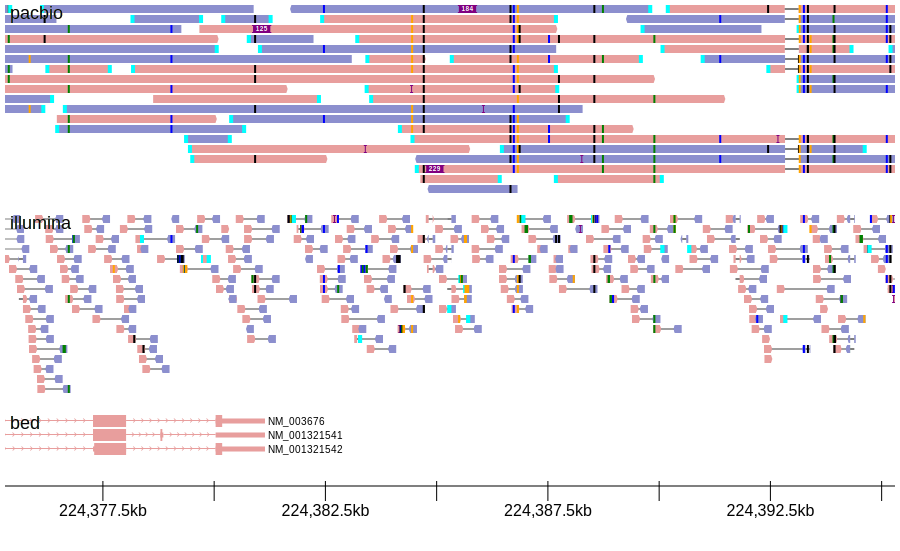

In [10]:
dataset_paths = {"pacbio":"data/pacbio.chr1.bam",
                 "illumina":"data/illumina.chr1.bam",
                 "bed":"data/chr1_200mb.refseq.sorted.bed.gz"}
reference = "ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/technical/reference/" \
            "phase2_reference_assembly_sequence/hs37d5.fa.gz"

chrom = "chr1"
start = 224375300
end =   start + 20000

doc = genomeview.visualize_data(dataset_paths, chrom, start, end, reference)
doc.get_tracks("pacbio")[0].min_indel_size = 50
doc.get_tracks("pacbio")[0].min_insertion_label_size = 100
doc

In [11]:
genomeview.save(doc, "fig1.svg")

# Remote access

Note that the mappability track displayed below requires [pyBigWig](https://github.com/deeptools/pyBigWig) to be installed, eg by running `pip install pyBigWig`.

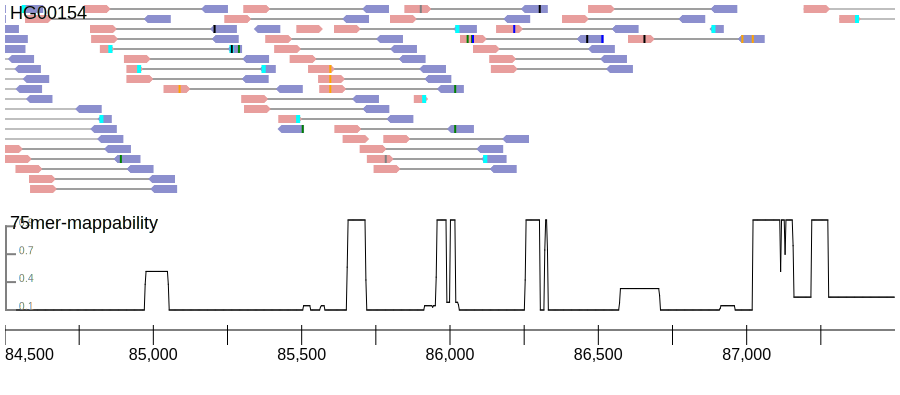

In [12]:
start = 84500
bam = "ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/phase1/data/HG00154/alignment/" \
      "HG00154.mapped.ILLUMINA.bwa.GBR.low_coverage.20101123.bam"
mappability = "http://hgdownload.cse.ucsc.edu/goldenPath/hg19/encodeDCC/wgEncodeMapability/" \
              "wgEncodeCrgMapabilityAlign75mer.bigWig"
ref = "ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/technical/reference/phase2_reference_assembly_sequence/hs37d5.fa.gz"

doc = genomeview.visualize_data(
    {"HG00154":bam, 
     "75mer-mappability":mappability},
    "chr1", start, start+3000, 
    reference_path=ref)


doc

# Example extension - new VCF track

Genomeview doesn't ship with a built-in VCF genomic variant viewer (primarily because the format is incredibly heterogeneous and there are lots of different types of data that could be visualized). However, it's quite easy to throw together a VCFTrack, demonstrated below.

This is a good starting point if you're interested in developing a track visualizing a new type of data, or in further fleshing out VCF visualization.

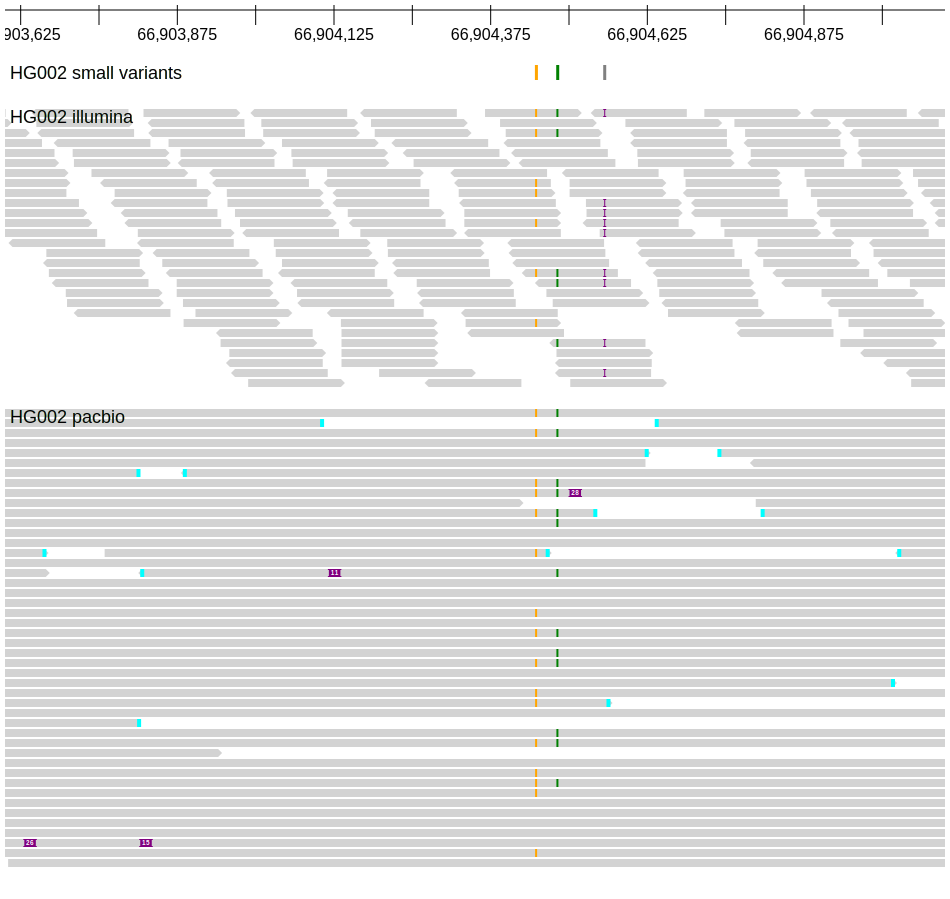

In [13]:
import pysam

def color_by_nuc(interval):
    colors = {"A":"blue", "C":"orange", "G":"green", "T":"black", "N":"gray"}
    return colors.get(str(interval.variant.alts[0]).upper(), "gray")

class VCFTrack(genomeview.IntervalTrack):
    def __init__(self, vcf_path, name=None):
        super().__init__([], name=name)
        
        self.vcf_path = vcf_path
        self.vcf = pysam.VariantFile(vcf_path)
        
        # ordinarily, IntervalTrack looks for intervals in a pre-loaded list of intervals;
        # here, we instead make this instance into an interator to load variants
        # from the vcf as needed
        self.intervals = self
        
        self.color_fn = color_by_nuc
        self.row_height = 15
        self.min_variant_pixel_width = 3
        
    def __iter__(self):
        chrom = genomeview.match_chrom_format(self.scale.chrom, self.vcf.header.contigs)
        start, end = self.scale.start, self.scale.end
        
        for variant in self.vcf.fetch(chrom, start, end):
            interval = genomeview.Interval(variant.id, variant.chrom, variant.start, variant.stop+1, None)
            interval.variant = variant
            yield interval
            
    def draw_interval(self, renderer, interval):
        # overriding this method isn't really necessary - we're just going to make
        # sure that every variant is at least several screen pixels wide, even
        # if we're zoomed pretty far out
        start = self.scale.topixels(interval.start)
        end = self.scale.topixels(interval.end)
        
        if end - start < self.min_variant_pixel_width:
            mid = (end + start) / 2
            start = mid - self.min_variant_pixel_width/2
            end = mid + self.min_variant_pixel_width/2
        
        row = self.intervals_to_rows[interval.id]
        top = row * (self.row_height + self.margin_y)
        
        color = self.color_fn(interval)

        yield from renderer.rect(start, top, end-start, self.row_height, fill=color, 
                                 **{"stroke":"none"})
       
        
chrom = "14"
start = 66903600
end = start + 1500
   
doc = genomeview.Document(950)

gv = genomeview.genomeview.GenomeView(chrom, start, end, "+", source)

axis = genomeview.axis.Axis()
gv.add_track(axis)

variant_track = VCFTrack("data/hg002.chr14.vcf.gz",
                        "HG002 small variants")
gv.add_track(variant_track)

bam_track = SingleEndBAMTrack("data/illumina.chr14.bam", "HG002 illumina")
bam_track.color_fn = lambda x: "lightgray"
gv.add_track(bam_track)

bam_track = SingleEndBAMTrack("data/pacbio.chr14.bam", "HG002 pacbio")
bam_track.min_indel_size = 10
bam_track.color_fn = lambda x: "lightgray"
gv.add_track(bam_track)

doc.elements.append(gv)

doc